In [12]:
%load_ext autoreload
%autoreload 2

import sys
import os

root_path = '../'
sys.path.append(os.path.join(root_path, 'code', 'core'))

import pse
import utils 
import numpy as np 
import itertools
import math
import networkx as nx
import matplotlib.pyplot as plt

from ranking_utils import RankingUtils
from mallows import Mallows
from ws_ranking import *
import numpy as np
from tensorly.decomposition import parafac

import time

np.random.seed(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
d = 5
r_utils = RankingUtils(d)
r1 = Ranking([0,1,2,3,4],r_utils)
r2 = Ranking([4,3,2,1,0],r_utils)
centers = [ r1, r2 ] 

In [20]:
def generate_true_rankings(d, n):
    ''' Sample from discrete distribution
    '''
    r_utils = RankingUtils(d)
    centers = [r_utils.get_random_ranking() for _ in range(k)]
    
    Y_inds = np.random.choice(a=np.arange(k), p=w, size=n)
    Y = [centers[Y_ind] for Y_ind in Y_inds]
    return Y, Y_inds

def sample_mallows_LFs(Y, m, thetas, p=None, d_mask=None):
    # p = None means sample full rankings
    # else each alternative will appear in at least p fraction of LFs.
    n = len(Y)
    d = len(Y[0])
    print('actual perm length', d)

    thetas = np.array(thetas)
    r_utils = RankingUtils(d)

    # get LFs
    # TODO reimplement this using inverse CDF 
    lst_mlw = [Mallows(r_utils, theta) for theta in thetas ]
    L = [[mlw.sample(y)[0] for mlw in lst_mlw] for y in Y]

    return L 

# compute psuedo-euclidean embeddings
def compute_pse(Y, L, r_utils, dim=0):
    # assumes hash function is implemented by the class of obj.
    unique_obj = set(Y)
    n, m = len(L), len(L[0])
    for i in range(len(L)):
        for j in range(len(L[0])):
            unique_obj.add(L[i][j])
    
    # compute pairwise distances b/w unique objs
    unique_obj_lst = list(unique_obj)
    map_obj_id = {k: v for v, k in enumerate(unique_obj_lst)}
    map_id_obj = unique_obj_lst 

    D = [[r_utils.kendall_tau_distance(r1, r2)**2 for r2 in unique_obj] for r1 in unique_obj]
    D = np.array(D) 
    #print(D.shape)

    X, tk = pse.pseudo_embedding(D, dim)
    s = len(D)
    rec = np.zeros((s, s))
    err = 0
    for i in range(s):
        for j in range(s):
            rec[i,j] = np.abs(np.linalg.norm(X[i,:tk]-X[j,:tk])**2 - np.linalg.norm(X[i,tk:]-X[j,tk:])**2)
            if i != j:
                err += np.abs((np.sqrt(D[i,j])-np.sqrt(rec[i,j])))/np.sqrt(D[i,j])
    err /= (s*(s-1))
    #print(f"Reconstruction error = {err}")
    #print(D)
    Y_emb = np.array([X[map_obj_id[y]] for y in Y])
    L_emb = np.array([ [ X[map_obj_id[L[i][j]]]  for i in range(n)] for j in range(m) ] )

    return Y_emb, L_emb, X, tk

def get_estimated_w_mu(L_emb):
    T_hat = (L_emb[0, :, :][:, :, None, None] * L_emb[1, :, :][:, None, :, None] * L_emb[2, :, :][:, None, None, :]).mean(axis=0)


    t1 = time.time()
    w_hat, mu_hat = parafac(T_hat, rank=k, normalize_factors=True)
    print(time.time() - t1)

    T_reconstructed = (mu_hat[0])[:, None, None] * (mu_hat[1])[None, :, None] * (mu_hat[2])[None, None, :]
    T_reconstructed = T_reconstructed @ w_hat
    
    mse = ((T_reconstructed - T_hat) ** 2).mean()
    #print(f'mse={mse}')

    return w_hat, mu_hat

compute_mse = lambda a, b: np.mean((a - b) ** 2)
compute_sign_mse = lambda a, b: np.min([compute_mse(a, b), compute_mse(a, -b)])




# Compute all of the rankings, probabilities
# p(ranking) = 1/Z * exp(-theta * d(center, ranking))
# brute force:
# compute Z (use itertools.... permutations)
# there will be a p(ranking) for each center
# 

# New sampling code
# Sample a center
# Since we have the full table of probabilities, use CDF-based sampling
# 

# True value of mu_a 



In [21]:
# Draw LF samples 
# 

mse_reses = []

ns = [1_00]
for n in ns:
    print(n)

    #####
    k = 2 # Number of centers/components
    d = 4 # Num items in rankings
    #n = 100 # Num examples
    max_m = 3 # Num LFs
    w = np.ones(k) / k # TODO de-uniformize the prior
    ######

    mse_res = np.zeros((2, k, max_m))

    theta_star = np.array([0.8, 0.9, 1.0])


    # New samples
    r_utils = RankingUtils(d)
    Y, Y_inds = generate_true_rankings(d, n)
    L = sample_mallows_LFs(Y, max_m, theta_star)

    # Pseudo-Euclidean embeddings
    Y_emb, L_emb, X, tk = compute_pse(Y, L, r_utils, dim=0)
    Y_emb_pos, Y_emb_neg = Y_emb[:, :tk], Y_emb[:, tk:]
    L_emb_pos, L_emb_neg = L_emb[:, :, :tk], L_emb[:, :, tk:]

    # Tensor decomposition for + -
    w_hat_pos, mu_hat_pos = get_estimated_w_mu(L_emb_pos)
    w_hat_neg, mu_hat_neg = get_estimated_w_mu(L_emb_neg)

    #print(mu_hat_pos)
    #print(mu_hat_neg)

    mu_hat_neg = np.array(mu_hat_neg)
    mu_hat_pos = np.array(mu_hat_pos)
    print(f'mu_hat_pos.shape: {mu_hat_pos.shape}')
    print(f'mu_hat_neg.shape: {mu_hat_neg.shape}')


    





    def get_expected_dist(L_emb, Y_emb):
        expected_dist = np.zeros((k, max_m))
        for c in range(k):
            for i in range(max_m):
                expected_dist[c, i] = (np.linalg.norm(L_emb[i, :, :][Y_inds == c] - Y_emb[Y_inds == c], axis=1) ** 2).mean()

        return expected_dist

    exp_dists_pos = get_expected_dist(L_emb_pos, Y_emb_pos)
    exp_dists_neg = get_expected_dist(L_emb_neg, Y_emb_neg)

    mu_hat_pos = np.array(mu_hat_pos)
    mu_hat_neg = np.array(mu_hat_neg)
    print(mu_hat_pos.shape)
    print(mu_hat_neg.shape)



    # Expected distance mu
    # 





    mu_hat_pos = np.array(mu_hat_pos)
    mu_hat_neg = np.array(mu_hat_neg)

    for lf in range(max_m):
        for cent in range(k):
            # Instead, compute mu using the true expectation

            # Compute positive
            mu = L_emb_pos[lf][Y_inds == cent, :].mean(axis=0)
            mu /= np.linalg.norm(mu)
            mse_res[0, cent, lf] += compute_sign_mse(mu, mu_hat_pos[lf, :, cent])

            # Compute negative
            mu = L_emb_neg[lf][Y_inds == cent, :].mean(axis=0)
            mu /= np.linalg.norm(mu)
            mse_res[1, cent, lf] += compute_sign_mse(mu, mu_hat_neg[lf, :, cent])

    print(mse_res)
    mse_reses.append(mse_res)



100
actual perm length 5
0.007146120071411133
0.08749580383300781
mu_hat_pos.shape: (3, 10, 2)
mu_hat_neg.shape: (3, 35, 2)
(3, 10, 2)
(3, 35, 2)
[[[1.20914242e-04 5.45343966e-04 6.68687934e-05]
  [6.63977756e-04 8.58971229e-05 5.33763145e-04]]

 [[3.09463932e-03 1.62787652e-03 1.53991461e-03]
  [1.30201856e-02 3.52315348e-03 3.37925280e-02]]]


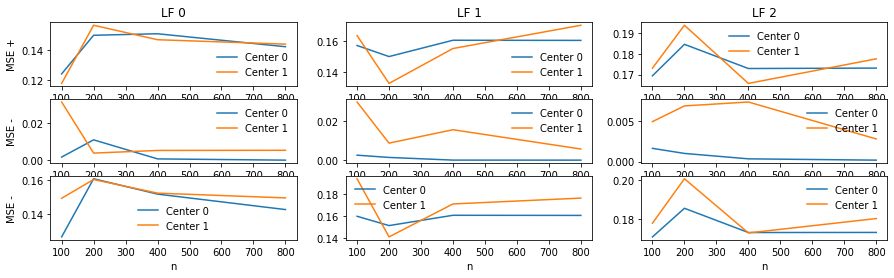

In [105]:
mse_reses = np.array(mse_reses)
mse_reses.shape

fig, axs = plt.subplots(3, max_m, figsize=(max_m * 5, 4))

start = 0
end = len(ns)

for lf in range(max_m):
    axs[0, lf].set_title(f'LF {lf}')
    for center in range(k):
        axs[0, lf].plot(ns[start:end], mse_reses[start:end, 0, center, lf], label=f'Center {center}')
    axs[0, lf].legend(frameon=False)
    axs[0, 0].set_ylabel('MSE +')

    for center in range(k):
        axs[1, lf].plot(ns[start:end], mse_reses[start:end, 1, center, lf], label=f'Center {center}')
        axs[1, lf].set_xlabel('n')
    axs[1, lf].legend(frameon=False)
    axs[1, 0].set_ylabel('MSE -')

    for center in range(k):
        axs[2, lf].plot(ns[start:end], 
            mse_reses[start:end, 0, center, lf] \
                + mse_reses[start:end, 1, center, lf], 
            label=f'Center {center}')
        axs[2, lf].set_xlabel('n')
    axs[2, lf].legend(frameon=False)
    axs[2, 0].set_ylabel('MSE -')


plt.show()

In [261]:
mu_hat_pos.shape

(3, 10, 2)

In [248]:
mu_hat_pos = np.array(mu_hat_pos)
np.linalg.norm(mu_hat_pos, axis=1).T ** 2

array([[1., 1., 1.],
       [1., 1., 1.]])

In [258]:
Y_emb_pos.shape

(1000, 10)

In [256]:
mu_hat_pos.shape

(3, 10, 2)

In [282]:
# embedding for center 0
mu0 = Y_emb_pos[Y_inds == 0, :][0]
mu0 /= np.linalg.norm(mu0)

# embedding for center 1
mu1 = Y_emb_pos[Y_inds == 1, :][0]
mu1 /= np.linalg.norm(mu1)

In [283]:
mu1

array([-0.08503496,  0.27946345, -0.04941446, -0.12045695, -0.01624838,
        0.04755848, -0.3921985 ,  0.40385568,  0.30539595, -0.69642371])

In [313]:
lf_2_mu_hat_pos_1 = mu_hat_pos[2, :, 1]
lf_2_mu_hat_pos_1

array([-0.06362067, -0.11258569,  0.08012212,  0.05400758, -0.05670742,
        0.2910298 ,  0.0060958 , -0.90074697,  0.02961498, -0.27160103])

In [314]:
np.dot(mu1, lf_2_mu_hat_pos_1)

-0.18972490451311308